In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from pathlib import Path
import os

In [2]:
directory = Path(os.getcwd())
data = directory.joinpath('data')
train = data.joinpath('train')
val = data.joinpath('val')
for i in data, train, val:
    if not i.exists():
        i.mkdir()
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])

In [3]:
trainset = datasets.MNIST(train, download=False, train=True, transform=transform)
valset = datasets.MNIST(val, download=False, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
data_iter = iter(trainloader)

images, labels = data_iter.next()

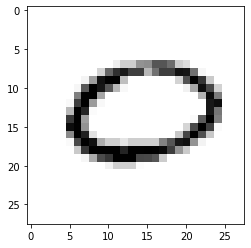

In [5]:
plt.imshow(images[3].numpy().squeeze(), cmap='gray_r');

In [56]:
labels[3]

tensor(9)

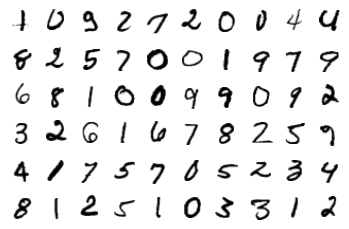

In [58]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [59]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [60]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [73]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0036, -0.0036, -0.0036,  ..., -0.0036, -0.0036, -0.0036],
        [-0.0017, -0.0017, -0.0017,  ..., -0.0017, -0.0017, -0.0017],
        [ 0.0019,  0.0019,  0.0019,  ...,  0.0019,  0.0019,  0.0019],
        ...,
        [-0.0019, -0.0019, -0.0019,  ..., -0.0019, -0.0019, -0.0019],
        [-0.0034, -0.0034, -0.0034,  ..., -0.0034, -0.0034, -0.0034],
        [-0.0091, -0.0091, -0.0091,  ..., -0.0091, -0.0091, -0.0091]])


In [77]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.6477417687236119
Epoch 1 - Training loss: 0.2856144230487123
Epoch 2 - Training loss: 0.22156631933060536
Epoch 3 - Training loss: 0.1776522240444605
Epoch 4 - Training loss: 0.14887222670701775
Epoch 5 - Training loss: 0.1265717425695392
Epoch 6 - Training loss: 0.10885191069486966
Epoch 7 - Training loss: 0.09742283253575057
Epoch 8 - Training loss: 0.08860163156515055
Epoch 9 - Training loss: 0.07859182844101302
Epoch 10 - Training loss: 0.07218751980106967
Epoch 11 - Training loss: 0.06522092788911132
Epoch 12 - Training loss: 0.05987840003248598
Epoch 13 - Training loss: 0.056110903068926174
Epoch 14 - Training loss: 0.050583873437082115

Training Time (in minutes) = 2.253138999144236


In [96]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='gray_r')
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 7


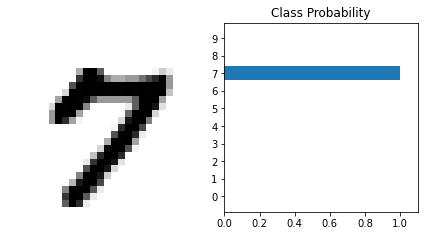

In [100]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [104]:
correct_count, all_count = 0, 0
for images,labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
                logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
        correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 157

Model Accuracy = 0.9681528662420382


In [106]:
torch.save(model, directory.joinpath('nn_model.pt'))

In [6]:
model = torch.load('app/models/nn_model.pt')

In [40]:
imgs = [img.view(1, 28**2).tolist()[0] for img in images]

In [37]:
len(imgs)

64

In [47]:
a = torch.Tensor(imgs)

In [48]:
with torch.no_grad():
    logps = model(a)

ps = torch.exp(logps)

In [60]:
[np.argmax(i).tolist() for i in ps]

[8,
 2,
 1,
 0,
 9,
 1,
 6,
 4,
 0,
 2,
 2,
 1,
 2,
 1,
 0,
 9,
 5,
 0,
 5,
 7,
 6,
 4,
 1,
 9,
 8,
 8,
 1,
 7,
 6,
 1,
 3,
 4,
 6,
 0,
 5,
 8,
 8,
 2,
 5,
 2,
 6,
 8,
 9,
 0,
 8,
 1,
 9,
 6,
 9,
 7,
 1,
 1,
 1,
 5,
 4,
 6,
 3,
 3,
 4,
 5,
 3,
 6,
 9,
 7]